# Correlating spike trains

Recall that our research questions for this data set were:
- Does stimulation with a sine wave grating increase functional connectivity between neurons?
- If so, are increases in functional connectivity specific to the orientation of the stimulus?

We hypothesized that the answer to both questions would be "yes". Here we compute functional connectivity (correlation) between each pair of neurons in the data set, to answer these questions.

In functional connectivity, we are typically interested in how similar (correlated) the patterns of activity of neurons are over time. That is, if two neurons show increases in spike probabilities at similar times, relative to the presentation of the stimulus, they ware said to be more strongly functionally connected than two neurons that do not show similar response patterns. Because the PSTH characterizes the response of a neuron over time, averaged across many trials, these are what we use as input to the functional connectivity analysis. 

### Import packages

We previously talked about  SciPy as the library that provided a function for importing Matlab files. The SciPy library has many useful routines for general-purpose scientific work, including many statistical and machine learning functions. Here we import `scipy.stats` so that we can use its correlation functions. 

In [1]:
import scipy.io
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sc

### Read Data

In [2]:
psth = pd.read_csv('data/array_psth.csv', index_col=['orientation', 'channel'])

## Compute correlation matrix 

pandas has a `.corr()` method that computes a correlation matrix from a DataFrame. It correlates the *columns*, which is not what we want here, because in `psth`, each *row* is a histogram for a channel. So we chain the `.T` method with `.corr()`, which [**transposes**](https://en.wikipedia.org/wiki/Transpose) the matrix (i.e., turns rows into columns).

Below shows the result of doing this, selecting only for the 90 deg orientation condition using `.loc[]`

In [3]:
psth.loc[90].T.corr()

channel,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,87.0,88.0,89.0,90.0,91.0,92.0,93.0,94.0,95.0,96.0
channel,,,,,,,,,,,,,,,,,,,,,
1.0,1.000000,0.238563,0.423488,0.128975,0.269791,0.479225,0.248945,-0.219806,0.512869,0.432926,...,0.463790,0.473022,-0.145650,0.273202,0.110040,0.251273,-0.048002,0.105124,0.054993,0.515555
2.0,0.238563,1.000000,0.025632,0.456420,0.587844,0.473608,-0.024363,-0.093321,0.025971,0.328144,...,0.130844,0.453307,0.066870,0.468894,0.211208,0.499714,-0.116305,0.248561,0.092954,-0.029692
3.0,0.423488,0.025632,1.000000,0.010262,0.066449,0.238800,0.276581,-0.497510,0.687241,0.205504,...,0.464852,0.371010,-0.137143,0.073834,-0.088170,0.166111,0.093238,0.062264,0.032608,0.659222
4.0,0.128975,0.456420,0.010262,1.000000,0.712863,0.183854,-0.104642,-0.022657,-0.082394,0.254798,...,-0.071817,0.242038,0.058670,0.265128,0.212288,0.801012,-0.146054,0.227241,-0.028776,-0.110741
5.0,0.269791,0.587844,0.066449,0.712863,1.000000,0.466423,-0.022484,-0.203097,0.085330,0.384352,...,0.178379,0.525944,0.033639,0.466034,0.342811,0.750051,-0.236529,0.238580,0.109951,-0.000521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92.0,0.251273,0.499714,0.166111,0.801012,0.750051,0.370030,0.009153,-0.213115,0.120801,0.355121,...,0.155579,0.474052,0.021922,0.420295,0.277063,1.000000,-0.205899,0.323322,-0.000208,0.057672
93.0,-0.048002,-0.116305,0.093238,-0.146054,-0.236529,-0.279180,-0.027830,0.119022,0.006674,-0.134009,...,-0.162546,-0.227484,0.303400,-0.257258,-0.287259,-0.205899,1.000000,-0.099424,0.029799,0.056857
94.0,0.105124,0.248561,0.062264,0.227241,0.238580,0.206190,0.047246,-0.101033,0.066926,0.077246,...,0.083598,0.186342,0.039010,0.182056,0.078205,0.323322,-0.099424,1.000000,0.103832,0.050617


Correlation matrices with large numbers of values are much easier to make sense of when plotted with color representing the correlation values, rather than as a matrix of raw numbers. Below we do this, separately for each orientation. The plot on the right, below, is the same correlation matrix as shown above, just in a visual rather than tabular format.

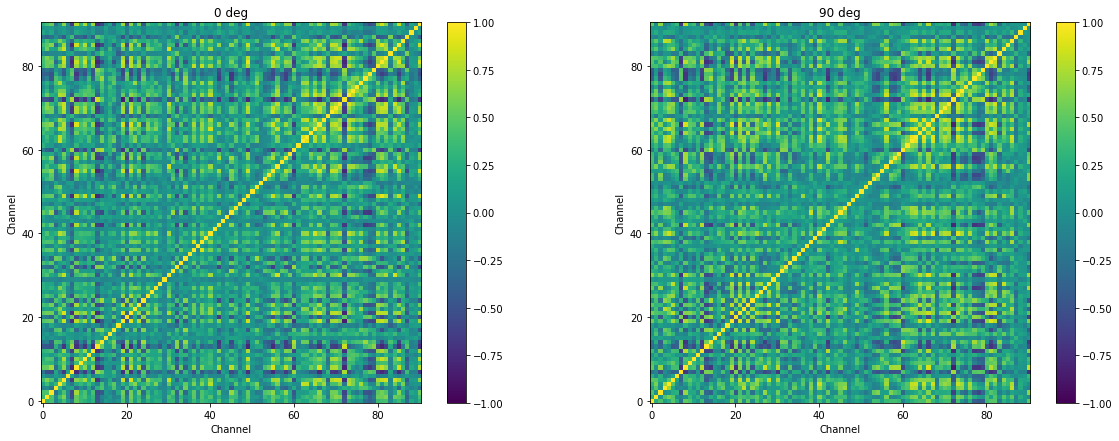

In [4]:
# Get levels of orientation from the data. Although we know these are 0 and 90, 
# and could hard-code these, our code is more robust and adaptable if we get
# these from the data itself
ortn_levs = psth.index.get_level_values('orientation').unique()


fig = plt.figure(figsize=[20, 7])
for oidx, ortn in enumerate(ortn_levs):
    ax = fig.add_subplot(1, len(ortn_levs), oidx+1)
    plt.imshow(psth.loc[ortn].T.corr(), clim=(-1, 1), cmap='viridis') 
    plt.colorbar()
    ax.invert_yaxis()
    plt.title(str(int(ortn)) + ' deg')
    plt.xlabel('Channel')
    plt.ylabel('Channel')
    
plt.show()

### Remove noisy channels

The authors who provided the data note that some of the channels were noisy. This may be due to technical issues in recording, or other issues. Regardless, We want to exclude these as their data do not appear to represent real neuronal activity. We first define a list of the noisy channels (provided by Nylen and Wallisch):

In [5]:
noisy = [7, 16, 32, 37, 39, 41, 43, 45, 47, 48, 51, 52, 54, 94, 95]

Since the channels are stored in one of the indexes of the `psth` DataFrame, we use the code below to select and remove the noisy channels. This is similar to code you've seen before, for selecting rows of a pandas DataFrame, using the `~` operator to take the inverse of whatever we select (i.e., "keep the channels that are *not* in `noisy`). 

In [6]:
psth = psth[~psth.index.get_level_values('channel').isin(noisy)]

Now we re-compute and plot the correlation matrices. These look very similar to the ones above, but if you look at the *x* and *y* axis ranges you can see there are fewer channels.

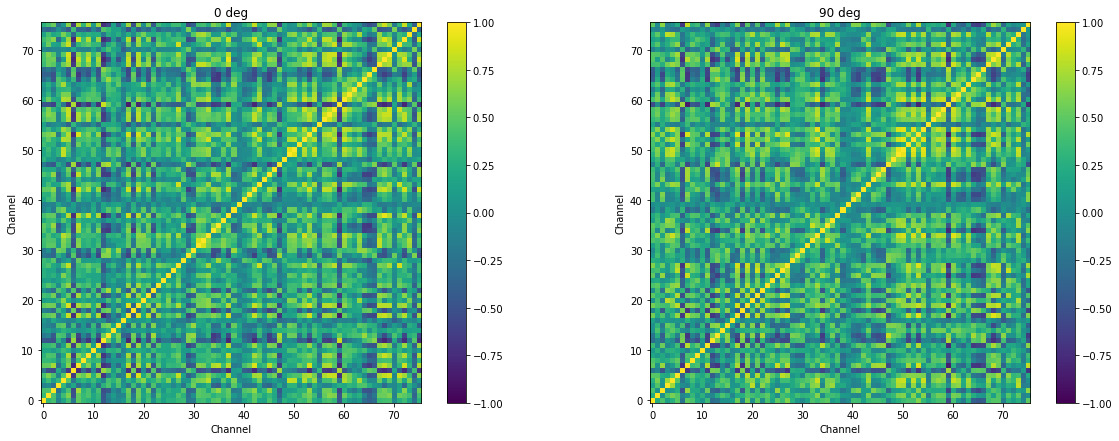

In [7]:
# Get levels of orientation from the data. Although we know these are 0 and 90, 
# and could hard-code these, our code is more robust and adaptable if we get
# these from the data itself
ortn_levs = psth.index.get_level_values('orientation').unique()


fig = plt.figure(figsize=[20, 7])
for oidx, ortn in enumerate(ortn_levs):
    ax = fig.add_subplot(1, len(ortn_levs), oidx+1)
    plt.imshow(psth.loc[ortn].T.corr(), clim=(-1, 1), cmap='viridis') 
    plt.colorbar()
    ax.invert_yaxis()
    plt.title(str(int(ortn)) + ' deg')
    plt.xlabel('Channel')
    plt.ylabel('Channel')
    
plt.show()

### Restrict time range

Finally, recall that the research question refer specifically to functional connectivity when stimuli are presented. So we should restrict the data we use to compute our correlation matrices, to the time points when the stimuli were presented. As noted when we introduced this experiment, each trial was 2150 ms long, but the first 150 ms was a fixation period, followed by a 2000 ms stimulus presentation. So we want to remove the first 150 ms of data.

Since our data are already in the form of histograms, that were computed over bins (ranges of time), we need to know how wide (i.e., how many milliseconds long) each bin is, so that we can figure out how many bins comprise the first 150 ms of the trials.

We know that the total length of the trials was 2150 ms, and we can use the number of columns in the `psth` DataFrame to derive the value for the total number of bins in each PSTH:

In [8]:
2150 / psth.shape[1]

7.992565055762082

Since this is not an even number, we can round it and save it as the variable `bin_width`:

In [9]:
bin_width = round(2150 / psth.shape[1])
print(bin_width)

8


We can now use `bin_width` to determine how many bins comprise the 150 ms baseline period:

In [10]:
baseline = round(150 / bin_width)
print(baseline)

19


So now we can use `.iloc[]` to select only the column numbers (bins) after the baseline:

In [11]:
psth_stim = psth.iloc[:, baseline:]
psth_stim

,,19,20,21,22,23,24,25,26,27,28,...,259,260,261,262,263,264,265,266,267,268
orientation,channel,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,22,33,29,27,27,19,35,24,48,62,...,19,12,12,13,16,16,15,19,21,11
90.0,1.0,27,26,29,30,30,19,31,41,68,69,...,15,17,22,14,27,21,19,21,18,17
0.0,2.0,1,0,4,2,5,1,3,14,12,24,...,1,1,1,0,1,0,0,2,0,0
90.0,2.0,2,1,5,1,1,3,3,8,18,12,...,3,2,1,0,2,2,3,1,2,0
0.0,3.0,0,2,0,0,1,3,0,6,7,7,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90.0,92.0,2,3,3,0,2,4,26,63,43,19,...,1,3,1,3,4,2,3,1,3,0
0.0,93.0,26,23,32,36,22,19,11,6,11,6,...,29,29,27,34,29,31,27,28,23,17
90.0,93.0,24,27,32,26,24,14,7,13,7,4,...,32,24,40,37,41,35,35,27,44,30


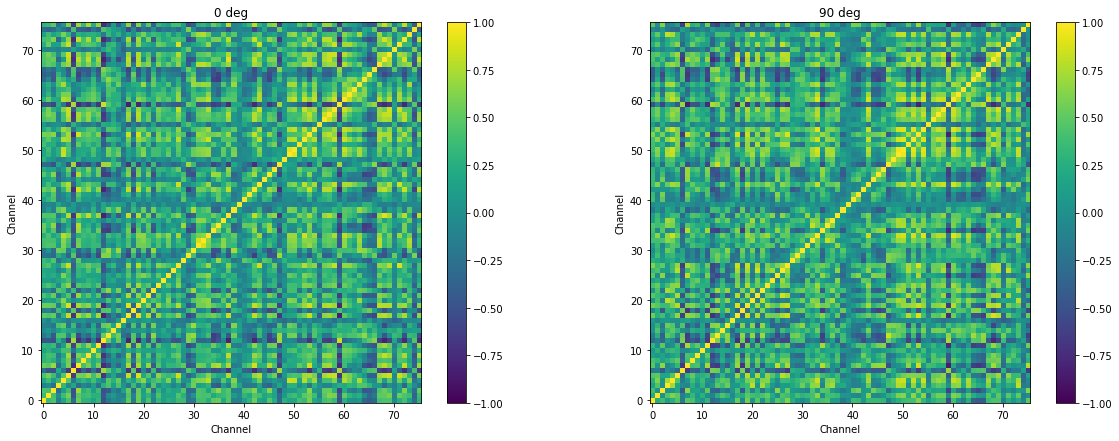

In [12]:
psth_stim = psth.iloc[:, baseline:]

fig = plt.figure(figsize=[20, 7])
for oidx, ortn in enumerate(ortn_levs):
    ax = fig.add_subplot(1, len(ortn_levs), oidx+1)
    plt.imshow(psth_stim.loc[ortn].T.corr(), clim=(-1, 1), cmap='viridis') 
    plt.colorbar()
    ax.invert_yaxis()
    plt.title(str(int(ortn)) + ' deg')
    plt.xlabel('Channel')
    plt.ylabel('Channel')
    
plt.show()